In [ ]:
!wget https://r0k.us/graphics/kodak/kodak/kodim23.png

In [ ]:
!wget https://hf.co/danjacobellis/walloc/resolve/main/RGB_Li_12c_J3_nf8_v1.0.2.pth

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance
from IPython.display import display
from torchvision.transforms import ToPILImage, PILToTensor
from walloc import walloc
from walloc.walloc import latent_to_pil, pil_to_latent
from einops import rearrange
class Config: pass

In [2]:
device = "cpu"
checkpoint = torch.load("RGB_Li_12c_J3_nf8_v1.0.2.pth",map_location="cpu",weights_only=False)
codec_config = checkpoint['config']
codec = walloc.Codec2D(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec = codec.to(device)
codec.eval();

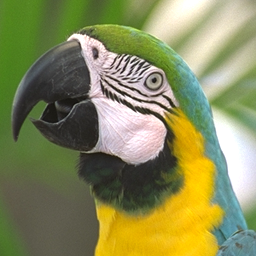

In [3]:
img = Image.open("kodim23.png").crop((60,150,60+256,150+256))
img

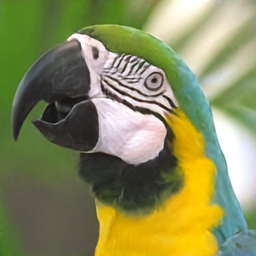

In [4]:
with torch.no_grad():
    codec.eval()
    x = PILToTensor()(img).to(torch.float)
    x = (x/255 - 0.5).unsqueeze(0).to(device)
    X = codec.wavelet_analysis(x,codec.J)
    x_hat, _, _ = codec(x)
ToPILImage()(x_hat[0]+0.5)

In [5]:
with torch.no_grad():
    codec.eval()
    print(f"x: {x.shape}")
    X = codec.wavelet_analysis(x,J=codec.J)
    print(f"X: {X.shape}")
    z0 = codec.encoder[0](X)
    print(f"z0: {z0.shape}")
    z1 = codec.encoder[1](z0)
    print(f"z1: {z1.shape}")
    z2 = codec.encoder[2](z1)
    print(f"z2: {z2.shape}")
    X_hat = codec.decoder(z2)
    print(f"X_hat: {X_hat.shape}")
    x_hat = codec.wavelet_synthesis(X_hat,J=codec.J)
    print(f"x_hat: {x_hat.shape}")

x: torch.Size([1, 3, 256, 256])
X: torch.Size([1, 192, 32, 32])
z0: torch.Size([1, 12, 32, 32])
z1: torch.Size([1, 12, 32, 32])
z2: torch.Size([1, 12, 32, 32])
X_hat: torch.Size([1, 192, 32, 32])
x_hat: torch.Size([1, 3, 256, 256])


In [6]:
def scale_for_display(img, n_bits):
    scale_factor = (2**8 - 1) / (2**n_bits - 1)
    lut = [int(i * scale_factor) for i in range(2**n_bits)]
    channels = img.split()
    scaled_channels = [ch.point(lut * 2**(8-n_bits)) for ch in channels]
    return Image.merge(img.mode, scaled_channels)

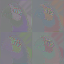

compression_ratio:  34.28810603418207
size:  5734


In [7]:
Y_pil = latent_to_pil(z2,codec.latent_bits,3)
display(scale_for_display(Y_pil[0], codec.latent_bits))
Y_pil[0].save('latent.webp',lossless=True)
webp = [Image.open("latent.webp")]
Y_rec = pil_to_latent(webp,12,codec.latent_bits,3)
assert(Y_rec.equal(z2))
print("compression_ratio: ", x.numel()/os.path.getsize("latent.webp"))
print("size: ", os.path.getsize("latent.webp"))

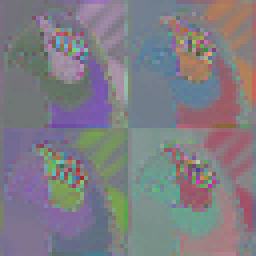

In [8]:
Y_pil = latent_to_pil(3*z2,codec.latent_bits,3)
display(scale_for_display(Y_pil[0], codec.latent_bits).resize((256,256),resample=Image.Resampling.NEAREST))
Y_pil[0].save('latent.webp',lossless=True)
webp = [Image.open("latent.webp")]
Y_rec = pil_to_latent(webp,12,codec.latent_bits,3)

In [9]:
X2 = rearrange(X[0], '(c u v) h w -> c u v h w', u=8, v=8)
X2 = X2/X2.std()
X2 = X2/20
X2 = X2.clamp(-0.5,0.5)
X2 = X2+0.5

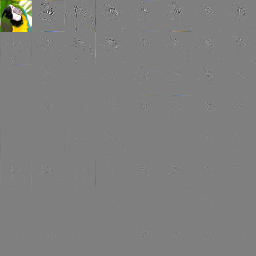

In [10]:
freq_bands = []
for u in range(8):
    for v in range(8):
        freq_band = ToPILImage()(X2[:,u,v,:,:])
        freq_bands.append(freq_band)
width, height = freq_bands[0].size
concat_image = Image.new('RGB', (width * 8, height * 8))
for i, band in enumerate(freq_bands):
    xi = (i % 8) * width
    yi = (i // 8) * height
    concat_image.paste(band, (xi, yi))
concat_image

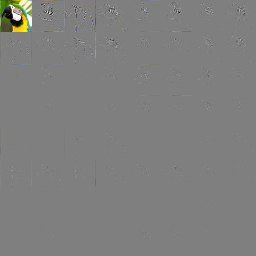

In [11]:
X3 = rearrange(X_hat[0], '(c u v) h w -> c u v h w', u=8, v=8)
X3 = X3/X3.std()
X3 = X3/20
X3 = X3.clamp(-0.5,0.5)
X3 = X3+0.5
freq_bands = []
for u in range(8):
    for v in range(8):
        freq_band = ToPILImage()(X3[:,u,v,:,:])
        freq_bands.append(freq_band)

width, height = freq_bands[0].size
concat_image = Image.new('RGB', (width * 8, height * 8))
for i, band in enumerate(freq_bands):
    xi = (i % 8) * width
    yi = (i // 8) * height
    concat_image.paste(band, (xi, yi))

concat_image

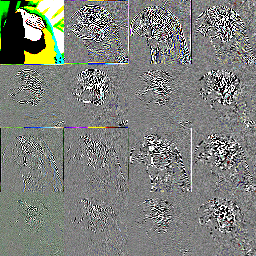

In [12]:
with torch.no_grad():
    X4 = rearrange(codec.wavelet_analysis(x, J=2)[0], '(c u v) h w -> c u v h w', u=4, v=4)
    X4 = X4/X4.std()
    X4 = 3*X4
    X4 = X4.clamp(-0.5,0.5)
    X4 = X4+0.5

freq_bands = []
for u in range(4):
    for v in range(4):
        freq_band = ToPILImage()(X4[:,u,v,:,:])
        freq_bands.append(freq_band)

width, height = freq_bands[0].size
concat_image = Image.new('RGB', (width * 4, height * 4))
for i, band in enumerate(freq_bands):
    xi = (i % 4) * width
    yi = (i // 4) * height
    concat_image.paste(band, (xi, yi))

concat_image

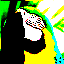

In [13]:
freq_bands[0]

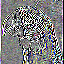

In [14]:
freq_bands[2]

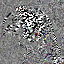

In [15]:
freq_bands[11]

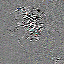

In [16]:
freq_bands[14]

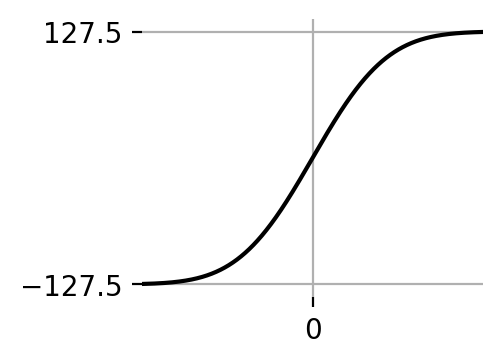

In [53]:
x_pre = torch.linspace(-200, 200, 1000)
x_compand = codec.encoder[1](x_pre)
fig = plt.figure(figsize=(2.2,1.8),dpi=200)
plt.plot(x_pre,x_compand,c='k')
plt.box(False)
plt.xlim([-200,200])
plt.yticks([-127.5,127.5])
plt.xticks([0])
plt.grid()
fig.savefig("companding.svg")

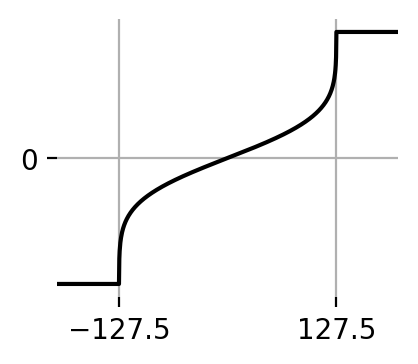

In [58]:
x_pre = torch.linspace(-200, 200, 1000)
x_compand = codec.decoder[0](x_pre)
fig = plt.figure(figsize=(2.2,1.8),dpi=200)
plt.plot(x_pre,x_compand,c='k')
plt.box(False)
plt.xlim([-200,200])
plt.xticks([-127.5,127.5])
plt.yticks([0])
plt.grid()
fig.savefig("decompanding.svg")

In [55]:
codec.decoder[0]

ToNormal()